# Analysis of temperature variation near Buenos Aires, Argentina

In this project I will try to answer the following question:
> Has the temperature in Buenos Aires, Argentina and nearby changed over the last decades?
>
> If so, how did it modify?

To answer this question, the data was collected from the National Centers for Environmental Information ([NCEI](https://www.ncei.noaa.gov/)), Daily Global Historical Climatology Network ([GHCN-Daily](https://www.ncei.noaa.gov/pub/data/ghcn/daily/)). The data will be cleaned, processed and transformed to ultimately show a figure that shows the maximum and minimum temperatures by day across the decade 2003-2012, and how these values compare to the ones of the decade 1973-1982.

---
## Data extraction

The first step was to convert the data obtained from the GHCN data base to csv files readable by *pandas*. The files obtained are in `.dly` format, and the specifications of this format is provided in [this file](ghcnd_all/readme.txt). This is done below in two steps.
1. write a `csv` file from [ghcnd-stations](ghcnd_all/ghcnd-stations.txt), which contains the information of all the weather stations in the database, such as ID, Name, Latitude and Longitude.
2. write a `csv` file from the selected weather stations nearby Buenos Aires.

In [1]:
import pandas as pd
import numpy as np
import csv
import os

In [2]:
# fields as given by ghcnd_all/ghcnd-version.txt
if not os.path.isdir("data-csv"):
    fields = [["ID", 1, 11],
              ["LATITUDE", 13, 20],
              ["LONGITUDE", 22, 30],
              ["ELEVATION", 32, 37],
              ["STATE", 39, 40],
              ["NAME", 42, 71],
              ["GSN", 73, 75],
              ["HCN/CRN", 77, 79],
              ["WMO ID", 81, 85]]

    # Modify fields to use Python numbering
    fields = [[var, start - 1, end] for var, start, end in fields]
    fieldnames = [var for var, start, end in fields]

    os.mkdir("data-csv")

    stations_txt = r"ghcnd_all/ghcnd-stations.txt"
    path, name = os.path.split(stations_txt)
    stations_csv = os.path.join("data-csv/", f"{os.path.splitext(name)[0]}.csv")

    with open(stations_txt, newline="") as f_txt, open(stations_csv, "w", newline="") as f_csv:
        writer = csv.writer(f_csv)
        writer.writerow(fieldnames)    # Write a header using the var names
        for line in f_txt:
            row = [line[start:end].strip() for var, start, end in fields]
            writer.writerow(row)
        
# load the recently created csv into a dataframe and select the stations near Buenos Aires
stations_csv = "data-csv/ghcnd-stations.csv"
df = pd.read_csv(stations_csv, low_memory=False)

latitude_bsas = df[df["NAME"].str.contains("AEROPARQUE JORGE NEWBERY")].loc[320]["LATITUDE"]
longitude_bsas = df[df["NAME"].str.contains("AEROPARQUE JORGE NEWBERY")].loc[320]["LONGITUDE"]

# create a list of IDs from all stations in Buenos Aires
id_bsas = df[(latitude_bsas-1 < df["LATITUDE"]) & (df["LATITUDE"] < latitude_bsas+1)
             & (longitude_bsas-1 < df["LONGITUDE"]) & ( df["LONGITUDE"] < longitude_bsas+1)]["ID"].tolist()

In [3]:
# fields as given by ghcnd_all/ghcnd-version.txt
if not os.path.isdir("data-csv/buenos-aires"):
    fields = [
        ["ID", 1, 11],
        ["YEAR", 12, 15],
        ["MONTH", 16, 17],
        ["ELEMENT", 18, 21]]

    offset = 22

    for value in range(1, 32):
        fields.append((f"VALUE{value}", offset,     offset + 4))
        fields.append((f"MFLAG{value}", offset + 5, offset + 5))
        fields.append((f"QFLAG{value}", offset + 6, offset + 6))
        fields.append((f"SFLAG{value}", offset + 7, offset + 7))
        offset += 8

    # Modify fields to use Python numbering
    fields = [[var, start - 1, end] for var, start, end in fields]
    fieldnames = [var for var, start, end in fields]

    os.mkdir("data-csv/buenos-aires")

    for dly_filename in os.scandir(r"ghcnd_all/ghcnd_all/"):
        path, name = os.path.split(dly_filename)
        if name.split(".")[0] not in id_bsas:
            continue

        csv_filename = os.path.join("data-csv/buenos-aires/", f"{os.path.splitext(name)[0]}.csv")

        with open(dly_filename, newline="") as f_dly, open(csv_filename, "w", newline="") as f_csv:
            writer = csv.writer(f_csv)
            writer.writerow(fieldnames)    # Write a header using the var names
            for line in f_dly:
                row = [line[start:end].strip() for var, start, end in fields]
                writer.writerow(row)

---
## Data cleaning

Now it is time to import the relevant `csv` files as *pandas DataFrame*, and clean them appropiately. For this project, only the maximum and minimum temperatures are needed, so everythin else is discarded. Then, all the data is binned in decades, 1973-1982, 1983-1992, 1993-2002, 2003-2012. Finally, the data was smoothed by binning, to obtain better shaped and more insightful curves.

In [4]:
df = pd.DataFrame()
for f_csv in os.scandir(r"data-csv/buenos-aires/"):
    df = pd.concat([df, pd.read_csv(f_csv)])
    
df = df.drop(["{}{}".format(name, idx) for idx in range(1, 32) for name in ["MFLAG", "QFLAG", "SFLAG"]], axis=1)
days = [idx for idx in range(1, 32)]
df["DAY"] = [days for _ in range(df.shape[0])]

df["VALUES"] = df[["VALUE{}".format(idx) for idx in range(1, 32)]].values.tolist()
df = (df.drop(["VALUE{}".format(idx) for idx in range(1, 32)], axis=1)
      .set_index(["ID", "YEAR", "MONTH", "ELEMENT"])
      .apply(pd.Series.explode).reset_index())

df["VALUES"] = df["VALUES"].apply(lambda x: x/10)
df = df[~((df["MONTH"] == 2) & (df["DAY"] == 29))]
df = df.sort_values(["YEAR", "MONTH", "DAY"]).replace({-999.9: np.nan})
df = df[["ID", "YEAR", "MONTH", "DAY", "ELEMENT", "VALUES"]]
df.head()

,ID,YEAR,MONTH,DAY,ELEMENT,VALUES
0,AR000875850,1908,9,1,TMAX,NaN
31,AR000875850,1908,9,1,TMIN,NaN
1,AR000875850,1908,9,2,TMAX,14.8
32,AR000875850,1908,9,2,TMIN,8.5
2,AR000875850,1908,9,3,TMAX,12.7


In [5]:
relevant_stations = []
for item in df["ID"].unique():
    if df[df["ID"] == item]["YEAR"].unique()[0] >= 1973 and df[df["ID"] == item]["YEAR"].unique()[-1] == 2022:
        relevant_stations.append(item)

df_all = df.drop(df[df["ID"].isin(relevant_stations)].index)
df_all.head()

,ID,YEAR,MONTH,DAY,ELEMENT,VALUES
0,AR000875850,1908,9,1,TMAX,NaN
31,AR000875850,1908,9,1,TMIN,NaN
1,AR000875850,1908,9,2,TMAX,14.8
32,AR000875850,1908,9,2,TMIN,8.5
2,AR000875850,1908,9,3,TMAX,12.7


The function defined below is used to smooth the data series by binning.

In [6]:
def average_smoothing(data, col, num=1):
    """
    Smoothes a data series by averaging with values before and after.
    """
    length = data[col].shape[0]
    ans = [data[col].iloc[idx] for idx in range(num)]
    
    for val in range(num, length-num):
        ans.append(np.mean([data[col].iloc[idx] for idx in range(val-num, val+num+1)]))
        
    ans.extend([data[col].iloc[idx] for idx in range(length-num, length)])
    data["{}_smooth".format(col)] = ans

Here the data corresponding to each decade is generated:

In [7]:
df_73_82 = df_all.loc[df_all["YEAR"] < 1983]
df_73_82 = df_73_82[(df_73_82["ELEMENT"] == "TMAX") | (df_73_82["ELEMENT"] == "TMIN")]
df_73_82 = (df_73_82.pivot_table(values="VALUES", index=["DAY", "MONTH"], columns="ELEMENT", aggfunc=[min, max])
           .drop([("min", "TMAX"), ("max", "TMIN")], axis=1))
df_73_82.columns = df_73_82.columns.droplevel()
df_73_82 = df_73_82.reset_index().sort_values(["MONTH", "DAY"])
average_smoothing(df_73_82, "TMAX", 4)
average_smoothing(df_73_82, "TMIN", 4)
df_73_82.head()

ELEMENT,DAY,MONTH,TMIN,TMAX,TMAX_smooth,TMIN_smooth
0,1,1,8.0,38.1,38.100000,8.000000
12,2,1,8.4,40.0,40.000000,8.400000
24,3,1,6.1,36.0,36.000000,6.100000
36,4,1,10.0,40.0,40.000000,10.000000
48,5,1,9.9,39.0,38.755556,8.488889


In [8]:
df_83_92 = df_all.loc[(df_all["YEAR"] >= 1983) & (df_all["YEAR"] < 1993)]
df_83_92 = df_83_92[(df_83_92["ELEMENT"] == "TMAX") | (df_83_92["ELEMENT"] == "TMIN")]
df_83_92 = (df_83_92.pivot_table(values="VALUES", index=["DAY", "MONTH"], columns="ELEMENT", aggfunc=[min, max])
           .drop([("min", "TMAX"), ("max", "TMIN")], axis=1))
df_83_92.columns = df_83_92.columns.droplevel()
df_83_92 = df_83_92.reset_index().sort_values(["MONTH", "DAY"])
average_smoothing(df_83_92, "TMAX", 4)
average_smoothing(df_83_92, "TMIN", 4)
df_83_92.head()

ELEMENT,DAY,MONTH,TMIN,TMAX,TMAX_smooth,TMIN_smooth
0,1,1,11.1,35.4,35.400000,11.100000
12,2,1,12.0,36.0,36.000000,12.000000
24,3,1,12.0,36.8,36.800000,12.000000
36,4,1,12.0,36.3,36.300000,12.000000
48,5,1,14.0,37.0,36.522222,11.855556


In [9]:
df_93_02 = df_all.loc[(df_all["YEAR"] >= 1993) & (df_all["YEAR"] < 2003)]
df_93_02 = df_93_02[(df_93_02["ELEMENT"] == "TMAX") | (df_93_02["ELEMENT"] == "TMIN")]
df_93_02 = (df_93_02.pivot_table(values="VALUES", index=["DAY", "MONTH"], columns="ELEMENT", aggfunc=[min, max])
           .drop([("min", "TMAX"), ("max", "TMIN")], axis=1))
df_93_02.columns = df_93_02.columns.droplevel()
df_93_02 = df_93_02.reset_index().sort_values(["MONTH", "DAY"])
average_smoothing(df_93_02, "TMAX", 4)
average_smoothing(df_93_02, "TMIN", 4)
df_93_02.head()

ELEMENT,DAY,MONTH,TMIN,TMAX,TMAX_smooth,TMIN_smooth
0,1,1,12.0,36.7,36.700000,12.000000
12,2,1,11.6,35.8,35.800000,11.600000
24,3,1,11.0,36.9,36.900000,11.000000
36,4,1,15.0,36.1,36.100000,15.000000
48,5,1,10.2,36.8,35.688889,12.133333


In [10]:
df_03_12 = df_all.loc[(df_all["YEAR"] >= 2003) & (df_all["YEAR"] < 2013)]
df_03_12 = df_03_12[(df_03_12["ELEMENT"] == "TMAX") | (df_03_12["ELEMENT"] == "TMIN")]
df_03_12 = (df_03_12.pivot_table(values="VALUES", index=["DAY", "MONTH"], columns="ELEMENT", aggfunc=[min, max])
           .drop([("min", "TMAX"), ("max", "TMIN")], axis=1))
df_03_12.columns = df_03_12.columns.droplevel()
df_03_12 = df_03_12.reset_index().sort_values(["MONTH", "DAY"])
average_smoothing(df_03_12, "TMAX", 4)
average_smoothing(df_03_12, "TMIN", 4)
df_03_12.head()

ELEMENT,DAY,MONTH,TMIN,TMAX,TMAX_smooth,TMIN_smooth
0,1,1,10.0,37.0,37.000000,10.000000
12,2,1,11.1,36.4,36.400000,11.100000
24,3,1,10.9,37.5,37.500000,10.900000
36,4,1,12.5,34.6,34.600000,12.500000
48,5,1,12.7,32.6,36.733333,12.844444


---
## Data visualization

Finally, the data from the first (1973-1982) and last (2003-2012) decades. It is clear how **the maximum temperatures have decreased**, while **the minimum temperatures have increased**.

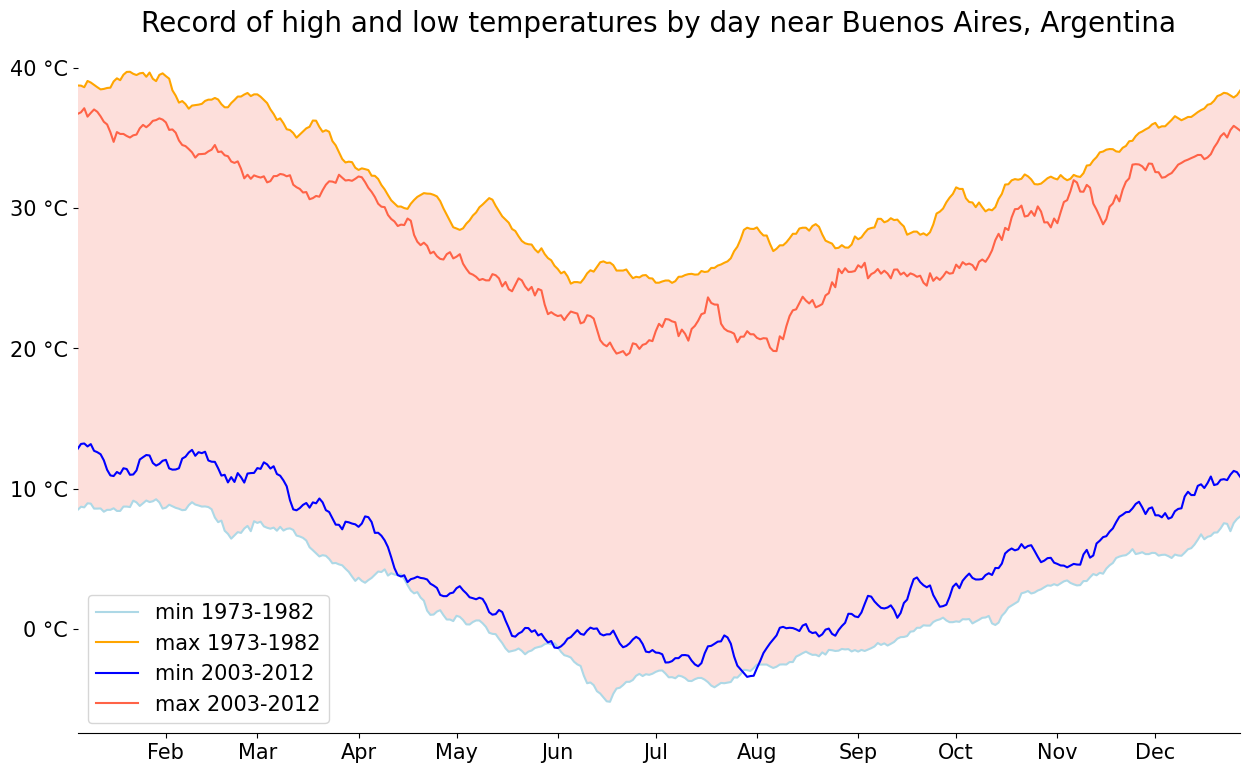

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import EngFormatter

days = pd.date_range("2022-01-01", periods=365).to_series().iloc[4:361]
plt.figure(figsize=(15,9))

plt.plot(days, df_73_82.iloc[4:361]["TMIN_smooth"], color="lightblue", label="min 1973-1982")
plt.plot(days, df_73_82.iloc[4:361]["TMAX_smooth"], color="orange", label="max 1973-1982")

plt.plot(days, df_03_12.iloc[4:361]["TMIN_smooth"], color="blue", label="min 2003-2012")
plt.plot(days, df_03_12.iloc[4:361]["TMAX_smooth"], color="tomato", label="max 2003-2012")

plt.gca().fill_between(days.index, df_73_82.iloc[4:361]["TMIN_smooth"], df_73_82.iloc[4:361]["TMAX_smooth"], facecolor="salmon", alpha=0.25)

plt.title("Record of high and low temperatures by day near Buenos Aires, Argentina", fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)

X = plt.gca().xaxis
Y = plt.gca().yaxis
Y.set_major_formatter(EngFormatter(unit=u"°C"))
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.margins(x=0)

locator = mdates.MonthLocator()
X.set_major_locator(locator)
X.set_major_formatter(mdates.DateFormatter('%b'))
plt.savefig("temp-comparison-bsas.png", dpi=300, bbox_inches="tight")
plt.show()